# **\[Essays\]** 강화학습 v3

신록예찬  
2023-08-12

# imports

In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 
import collections
import IPython
import random

# 기존알고리즘

In [6]:
BUFFER_SIZE = 500*20   # replay buffer size
BATCH_SIZE = 128     # minibatch size
GAMMA = 0.99          # discount factor

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = 4
        self.memory = collections.deque(maxlen=BUFFER_SIZE)  
        self.batch_size = BATCH_SIZE
        self.experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = 8
        self.action_size = 4
        self.seed = 0 

        # Q-Network
        self.net = torch.nn.Sequential(
            torch.nn.Linear(8,128), # 8은 state_size
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,4)) # 4는 action_size 
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0001)

        # Replay memory
        self.memory = ReplayBuffer()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_values = self.net(state)            

        if random.random() > eps:
            return np.argmax(action_values.data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        q_targets_next = self.net(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        ### Calculate expected value from local network
        q_expected = self.net(states).gather(1, actions)
        
        loss = torch.nn.functional.mse_loss(q_expected, q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [9]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

In [10]:
agent = Agent()

In [11]:
n_episodes = 2000
max_t = 500
eps_start = 1.0 
eps_end = 0.01 
eps_decay = 0.995

playtimes=[] 
scores = []                        # list containing scores from each episode
scores_window = collections.deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    state, _  = env.reset()
    score = 0
    for t in range(max_t):
        ## STEP1: 
        action = agent.act(state, eps)
        
        ## STEP2: 
        next_state, reward, done, _, _ = env.step(action)
        
        ## STEP3: 
        agent.step(state, action, reward, next_state, done)
        
        ## STEP4: 
        state = next_state
        
        ## STEP5: 
        score += reward
        
        if done:
            playtimes.append(t)
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
    if np.mean(scores_window)>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
        break

Episode 100 Average Score: -145.92  Playtime: 108.96
Episode 200 Average Score: -23.36   Playtime: 139.995
Episode 300 Average Score: 97.01    Playtime: 155.116
Episode 393 Average Score: 200.63   Playtime: 192.80
Environment solved in 393 episodes! Average Score: 200.63

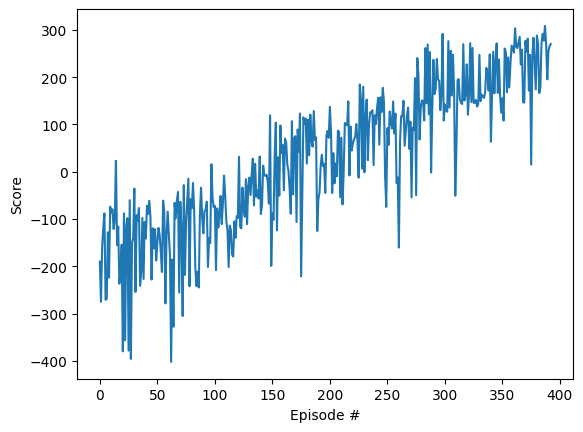

In [12]:
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

In [15]:
frames = []
agent = Agent()
agent.net.load_state_dict(torch.load('checkpoint.pth'))
state,_ = env.reset()
done = False
while not done:
    frames.append(env.render())
    action = agent.act(state)
    state, reward, done, _,_ = env.step(action)
env.close()

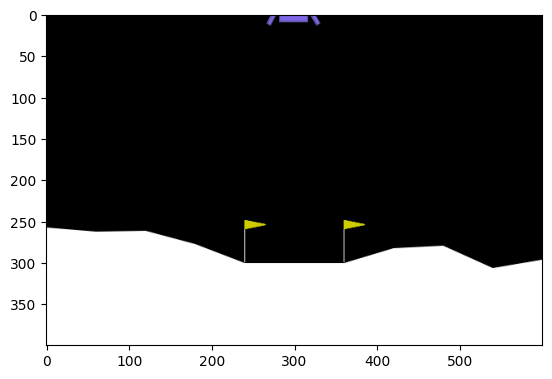

In [16]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(frames[::10][i]),frames=len(frames[::10]))

`-` 방법1

In [17]:
# ani.save('LunarLander-v2.mp4', writer='ffmpeg', fps=15, extra_args=['-vcodec', 'mpeg4'])

`-` 방법2

In [18]:
IPython.display.HTML(ani.to_jshtml())

# 1 experience

## test

In [2]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

In [3]:
net = torch.nn.Sequential(
    torch.nn.Linear(8,128), # 8은 state_size
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,4)) # 4는 action_size 

In [4]:
optimizr = torch.optim.Adam(net.parameters(), lr=0.0001)

In [5]:
current_state, _ = env.reset()

In [6]:
current_state

In [7]:
net(torch.tensor(current_state))

In [8]:
_action1 = net(torch.tensor(current_state)).argmax().item()
_action1

In [9]:
_action2 = random.choice([0,1,2,3])
_action2 

In [10]:
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])

In [11]:
[act(current_state,0.95) for i in range(20)]

In [12]:
[act(current_state,0.1) for i in range(20)]

In [13]:
action = act(current_state,0.05)

In [14]:
next_state, reward, terminated, truncated, info = env.step(action)

In [15]:
net(torch.tensor(next_state))

In [16]:
reward

In [17]:
qvalue_next_state = net(torch.tensor(next_state)).data.max().item()
qvalue_next_state

In [18]:
reward + 0.99 * qvalue_next_state

In [19]:
qvalue_current_state = net(torch.tensor(current_state)).max()
qvalue_current_state

In [20]:
loss = torch.mean((qvalue_current_state - (reward + 0.99 * qvalue_next_state))**2)

In [21]:
loss.backward()

In [22]:
optimizr.step()

In [23]:
net(torch.tensor(current_state))

## 코드정리

### env $\to$ agent: current_state

In [24]:
current_state, _ = env.reset()
current_state

### agent $\to$ env: action

In [25]:
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])

In [26]:
action = act(current_state,0.05)
action

### env $\to$ agent: reward,next_state

In [27]:
next_state, reward, terminated, truncated, info = env.step(action)

In [28]:
net(torch.tensor(next_state))

In [29]:
reward

### agent: update ($q$-value generating) network

In [30]:
qvalue_current_state = net(torch.tensor(current_state))[action]
qvalue_next_state = net(torch.tensor(next_state)).max().data
reward2 = reward + 0.99 * qvalue_next_state 
loss = torch.mean((qvalue_current_state - reward2)**2)

In [31]:
loss.backward()

In [32]:
optimizr.step()

# 리플레이버퍼사용

In [33]:
current_state_history = collections.deque(maxlen=50000)
action_history = collections.deque(maxlen=50000)
next_state_history = collections.deque(maxlen=50000)
terminated_history = collections.deque(maxlen=50000)
reward_history = collections.deque(maxlen=50000)
qvalue_current_state_history = collections.deque(maxlen=50000)
qvalue_next_state_history = collections.deque(maxlen=50000)

## episode=1

In [34]:
### env -> agent: current_state
current_state, _ = env.reset()
current_state_history.append(current_state)
current_state_history

### agent -> env: action
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])
action = act(current_state,1)
action_history.append(action)
action_history

### env -> agent: reward,next_state
next_state, reward, terminated, truncated, info = env.step(action)
next_state_history.append(next_state)
reward_history.append(reward)
terminated_history.append(terminated)

### agent: update ($q$-value generating) network
qvalue_current_state = net(torch.tensor(current_state))[action]
qvalue_current_state_history.append(qvalue_current_state)
qvalue_next_state = net(torch.tensor(next_state)).max().data
qvalue_next_state_history.append(qvalue_next_state)
#reward2 = reward + (0.99 * qvalue_next_state)*(~torch.tensor(terminated))
#loss = torch.mean((qvalue_current_state - reward2)**2)

## episode=2~100 정도까지 데이터를 쌓자

In [35]:
playtimes = [] 
scores = [] 

for e in range(100):
    current_state, _ = env.reset()
    eps = 1 
    score = 0 
    for t in range(500):        
        current_state = next_state ## 수정
        current_state_history.append(current_state)
        
        ### agent -> env: action
        act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])
        action = act(current_state,eps)
        action_history.append(action)
        
        ### env -> agent: reward,next_state
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state_history.append(next_state)
        reward_history.append(reward)
        terminated_history.append(terminated)

        ### agent: update ($q$-value generating) network
        qvalue_current_state = net(torch.tensor(current_state))[action]
        qvalue_current_state_history.append(qvalue_current_state)
        qvalue_next_state = net(torch.tensor(next_state)).max().data
        qvalue_next_state_history.append(qvalue_next_state)        

        ### recore score 
        score = score + reward

        ### check terminated         
        if terminated:
            playtimes.append(t)
            scores.append(score) 
            break

(loss계산을 위한 테스트코드)

In [36]:
idx = np.random.randint(0,len(current_state_history),size=128) 
current_state_sampled = torch.tensor(np.array(current_state_history)[idx],dtype=torch.float32)
actions_sampled = torch.tensor(np.array(action_history)[idx],dtype=torch.int64)
reward_sampled = torch.tensor(np.array(reward_history)[idx],dtype=torch.float32)
next_state_sampled = torch.tensor(np.array(next_state_history)[idx],dtype=torch.float32)
terminated_sampled = torch.tensor(np.array(terminated_history)[idx],dtype=torch.int64)

In [37]:
actions_sampled

In [38]:
qvalue_current_state = net(current_state_sampled).gather(1,actions_sampled.reshape(-1,1)).reshape(-1)
qvalue_next_state = net(next_state_sampled).max(axis=1)[0].detach()
loss_fn = torch.nn.MSELoss() 
loss = loss_fn(qvalue_current_state, reward_sampled + (0.99 * qvalue_next_state)*(1-terminated_sampled))

In [39]:
loss

In [40]:
optimizr.step()

# 최종알고리즘

In [41]:
current_state_history = collections.deque(maxlen=500*20)
action_history = collections.deque(maxlen=500*20)
next_state_history = collections.deque(maxlen=500*20)
terminated_history = collections.deque(maxlen=500*20)
reward_history = collections.deque(maxlen=500*20)    
def save(): 
    current_state_history.append(current_state)
    action_history.append(action)
    next_state_history.append(next_state)
    reward_history.append(reward)
    terminated_history.append(terminated)    
def sample():
    idx = np.random.randint(0,len(current_state_history),size=1) 
    current_state_sampled = torch.tensor(np.array(current_state_history)[idx],dtype=torch.float32)
    actions_sampled = torch.tensor(np.array(action_history)[idx],dtype=torch.int64)
    reward_sampled = torch.tensor(np.array(reward_history)[idx],dtype=torch.float32)
    next_state_sampled = torch.tensor(np.array(next_state_history)[idx],dtype=torch.float32)
    terminated_sampled = torch.tensor(np.array(terminated_history)[idx],dtype=torch.int64)
    return current_state_sampled, actions_sampled, reward_sampled, next_state_sampled, terminated_sampled

In [42]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(8,128), # 8은 state_size
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,4)) # 4는 action_size 

optimizr = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_fn = torch.nn.MSELoss() 
act = lambda state, eps: net(torch.tensor(state)).argmax().item() if eps < random.random() else random.choice([0,1,2,3])

In [43]:
playtimes = [] 
scores = [] 
eps = 1 
for e in range(2000):
    eps = eps*0.995
    current_state, _ = env.reset(seed=0)
    score = 0
    for t in range(500):
            
        ### agent -> env: action
        action = act(current_state,eps)
        
        ### env -> agent: reward,next_state
        next_state, reward, terminated, truncated, info = env.step(action)

        ### save
        save()
        ### agnet: update network
        if len(current_state_history) > 5000:         
            #### step1: prepare data
            current_state_sampled, actions_sampled, reward_sampled, next_state_sampled, terminated_sampled = sample()
            #### step2: loss 
            qvalue_current_state = net(current_state_sampled).gather(1,actions_sampled.reshape(-1,1))
            qvalue_next_state = net(next_state_sampled).max(axis=1)[0].detach()           
            loss = loss_fn(qvalue_current_state, reward_sampled + 0.99 * qvalue_next_state * (1-terminated_sampled))
            #### step3: backward 
            loss.backward()        
            #### step4: update 
            optimizr.step()        
        
        ### recore score 
        score = score + reward
        
        ### check terminated 
        if terminated:
            playtimes.append(t)
            scores.append(score) 
            break
        ### 
        current_state = next_state
        
    print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}\tExperience: {}'.format(e, np.mean(scores[-100:]), np.mean(playtimes[-100:]),len(current_state_history)), end="")
    if e % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(e, np.mean(scores[-100:]), np.mean(playtimes[-100:])))
        #torch.save(agent.network.state_dict(), 'checkpoint.pth')

Episode 0   Average Score: -262.47  Playtime: 68.00 Experience: 69
Episode 78  Average Score: -98.32   Playtime: 62.32 Experience: 50021Episode 100    Average Score: -132.78  Playtime: 64.05 Experience: 6574
Episode 120 Average Score: -163.03  Playtime: 69.24 Experience: 8386

/home/cgb2/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)